# A Data Science Perspective on Predicting Residential Real Estate Prices by John Foxworthy

# Abstract

What drives the price of housing?  Are there any characteristics that explain price behavior? How can we predict the next price?

For this project, I use a Data Science perspective, which applies statistical techniques to a business case with some tools of software development, especially Python. The chosen data set is for demonstration purposes only and comes from https://www.zillow.com/research/data/ , which is seasonally adjusted.  Narrative analytics from the Exploratory Data Analysis will drive the argument for the model selection.  AutoRegressive Integrated Moving Average (ARIMA) will be implemented followed by Exponential Smoothing to make prediction of next month's price     

# Introduction

The median sale price has no assumptions how each property sale price is grouped or distributed.  By taking the middle number of a particular month we can have the best representation of a monthly dataset.  An arithmetic average would be bias as the distribution of all the sale prices vary from one month to the next.  

For example, if a small series of months have a majority of sale prices on the lower end of values with a minority count on the higher end, then an average would underrepresent the higher end values and overrepresent the more common lower end values.  Conversely, higher end values with a smaller count on the lower end would underrepresent the lower end values and overrepresent the more common higher end values.  The median, however, does a better job in capturing the skewness of data over seveal months of time because it does not treat each datapoint equally by dividing the overall count.  

We begin, first by loading the data and we will see how skewness is a central theme to this project to capture the central tendency of the sale price of residential real estate . . . thereafter to eventually predict the next month's median sale price.  Below is an outline of the project.  

# I.     Importing the Time Series Data 

# II.    Exploratory Data Analysis

# III.   Setting Up ARIMA

# IV.   ARIMA Model

# V.    Exponential Smoothing

# VI.  Conclusion

# VII. Appendix

In [1]:
# Required General Libaries to Import 
import sys
import warnings
from datetime import datetime
import datetime as dt

# Data Science Analytics Libraries
import numpy as np
import pandas as pd
from scipy import stats

# Data Visualization Libaries 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

# I.  Importing the Time Series Data

In [2]:
# load data
df = pd.read_csv('/Users/lacivert/re/data.csv')

df = pd.DataFrame(df)

list(df.columns.values)

['Month', 'San_Francisco_Median_Price']

In [3]:
# Clean up missing values 
df.dropna(how='any', inplace=True)

In [4]:
# Descriptive Statistics Table
pd.options.display.float_format = '{:,.0f}'.format # Limit output to no decimal places
df.describe()

,San_Francisco_Median_Price
count,273
mean,"827,262"
std,"356,098"
min,"258,100"
25%,"593,450"
50%,"790,300"
75%,"914,800"
max,"1,520,200"


# II.  Exploratory Data Analysis 

After setting up the data, let's uncover the main characteristics of the time series for analysis before we model.  The findings below will drive model selection for prediction and more importantly reject other models.  As we will see below the distribution of median sale price has a constant theme.   

First, the descriptive statistics above shows the distribution of the data is skewed from the 273 observations from April 1996 to December 2018.  Regardless, if you take the average mean value of 827,262 or 790,300 representing 50 percentile, then there is a greater distance of datapoints left of the distribution.

In [5]:
# Assign variables for analysis 
sf = df.loc[:,'San_Francisco_Median_Price']

In [6]:
np.percentile(sf,50) - np.percentile(sf,25), np.percentile(sf,75) - np.percentile(sf,50)


(196850.0, 124500.0)

196,850 is greater than 124,500 so the higher end values are possibly long and sparse, while the lower end values are dense and more common. 

In [7]:
df.mean() - np.percentile(sf,25)

San_Francisco_Median_Price   233,812
dtype: float64

In [8]:
abs(df.mean() - np.percentile(sf,75))

San_Francisco_Median_Price   87,538
dtype: float64

233,812 is greater than 87,538 with the same theme, but exaggerated because of the arithmetic average.

In [9]:
df.mean()

San_Francisco_Median_Price   827,262
dtype: float64

Let us analyze the skewness further with data visualization.

Text(0.5, 1.0, 'Monthly Distplot\nApril 1996 - December 2018')

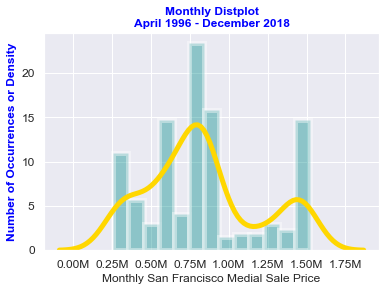

In [10]:
# Histogram of Median Sale Prices

sns.set(style="darkgrid") 
g = sns.distplot(sf, hist=True, axlabel = "Monthly San Francisco Medial Sale Price",  
                 kde_kws={"color": "gold", "lw": 5}, 
                 hist_kws={"linewidth": 5,"color": "darkcyan"})

# Format the horizontal and vertical axes
xlabels = ['{:,.2f}'.format(x) + 'M' for x in g.get_xticks()/1000000]
g.set_xticklabels(xlabels, fontsize=12)

ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()*10000000]
g.set_yticklabels(ylabels, fontsize=12)

# Label and Title 
plt.ylabel('Number of Occurrences or Density',color='blue',weight='bold')
plt.title('Monthly Distplot\nApril 1996 - December 2018', color='blue',weight='bold')

The distplot above with the blue colored discrete histogram and the best fit continuous yellow colored line provides an important level of understanding on the grouping of historical median sale prices and its distribution.  Not only do we not have a normal distribution, but there is no gradual increase from the lowest values to the central tendency such as the median from one bucket to the next.  Nor do we have gradual decrease from the median to the highest values of the median sale price in San Francisco.  Data visualization provides not one, but two humps in the monthly median values.  

Let us proceed with statistical metrics below to finish off our case for model selection.

In [11]:
stats.skew(sf)

0.4650429300892724

A positive skew number has the right tail of the distribution is longer than the left, while a normal distrubtion has a zero skew.

In [12]:
stats.kurtosis(sf)

-0.6098890366014929

Pearson definition of kurtosis has a normal distribution of zero and a negative kurtosis means thinner tails.  This is troublesome because if we had the opposite, which is fat tails, then we would have room for models with a normal distribution assumption.  Tails are a smaller quantity of the overall dataset compared to the larger quantity of the hump.  Let's verify if the dataset is normally distributed.   

The Shapiro–Wilk tests whether a given time series is normally distributed or not, which is helpful for relatively small sample sizes.  The statistical function will return two numbers.  The second number is the probability value or p - value and if it is 0.05 or greater then dataset is probably normal.  Otherwise, if the p - value less than 0.05, then the dataset is probably not normal.  The chance of rejecting the hypothesis when it is true is close to 5% regardless of sample size so we have a 95% level of confidence.

In [13]:
stats.shapiro(sf)

(0.9234578609466553, 1.2414844152708326e-10)

The p - value is very close to zero and therefore less than 0.05 so the data is probably not normal.

Exploratory Data Analysis concludes that the dataset is not normally distributed so models that assume normality will produce inaccurate predictions.  Multiple Linear Regression and related models assume a normal distribution so there will be a gap between the predicted values and the observed values, i.e. residuals.  There is enough information in the historical median sales price to implement a time series model like ARIMA below.  

# III.  Setting up ARIMA

ARIMA assumes historic values dictates the behaviour of the present and the inputted time series data is stationary, i.e. the mean and variance do not change over time.  The most common median sales prices of the dataset can produce an arithmetic mean . . . and how the median sale price varies around that mean is the variance.  The evolution of a process is a single trend term, which has a linear relationship between time and your outcome.  Each step in time, i.e. an additional month, has a changing outcome as our knowledge completes at each iterative step.  We look back a certain distance to provide the means to look forward, for one month or one increment.  Shocks and outliers fade over time, month by month, as the ARIMA model adjusts and the observable data absorbs the underlying effects of randomness.

We first build ARIMA from an extension of multiple linear regression with differencing to make the time series data stationary.  Subtracting each term from the following term, i.e. a single median sale price month from the next one, we build the AR, i.e. the autoregression of ARIMA.  Yesterday's outcome based on today's outcome with some left over noise or error term.  

Thereafter, the moving average, MA, which changes the focus on the prior error term that leads us to ARMA.  If our test results are statistically signficant with tame residuals, then we can proceed to integrate with ARIMA.  First, we build a date index to process the model using the Pandas library, pd.        

In [14]:
df.index = pd.to_datetime(df.Month)

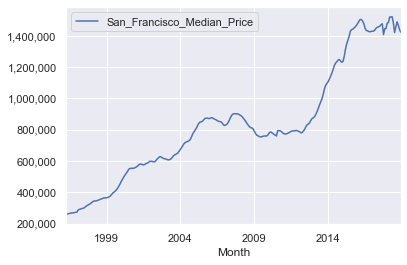

In [15]:
h = df.plot()
h.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

In [16]:
df.drop(columns=['Month'])

,San_Francisco_Median_Price
Month,
1996-04-01,258100
1996-05-01,260850
1996-06-01,262750
1996-07-01,265000
1996-08-01,267100
1996-09-01,267950
1996-10-01,268350
1996-11-01,269900
1996-12-01,271800


In [17]:
df['price'] = pd.to_numeric(df.San_Francisco_Median_Price, errors='coerce')

In [18]:
# sanity check
pd.options.display.float_format = '{:,.0f}'.format # Limit output to no decimal places
df.describe()

,San_Francisco_Median_Price,price
count,273,273
mean,"827,262","827,262"
std,"356,098","356,098"
min,"258,100","258,100"
25%,"593,450","593,450"
50%,"790,300","790,300"
75%,"914,800","914,800"
max,"1,520,200","1,520,200"


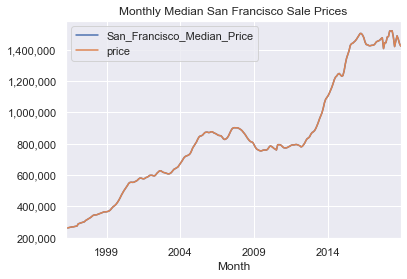

In [19]:
df.index = pd.to_datetime(df.Month)
j = df.plot()
j.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.title('Monthly Median San Francisco Sale Prices')
plt.show()

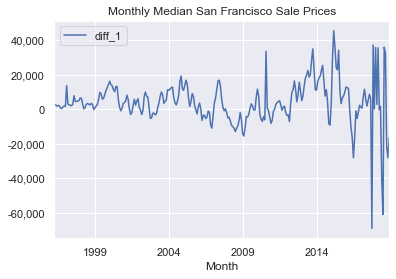

In [20]:
# Plotting the difference 

df['diff_1'] = df.price - df.price.shift()
k = df.plot(y='diff_1')
k.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.title('Monthly Median San Francisco Sale Prices')
plt.show()

Good time series reverting behavior with the differencing above.

Below is the partial autocorrelation function (PACF) that takes the correlation of time series with a lagged version of itself.  The correlation lags are the bars so a PACF of one is the correlation of our first series with itself lagged by one.  The above diff_1 plot mirrors the PACF plot below.

Text(0.5, 1.0, 'Monthly Median San Francisco Sale Price')

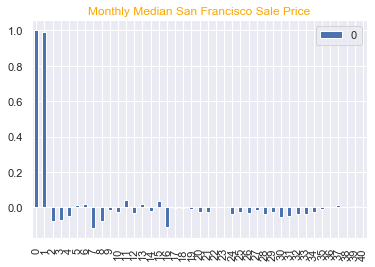

In [21]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(df.price))
x_acf.plot(kind='bar')
plt.title("Monthly Median San Francisco Sale Price", color="orange")

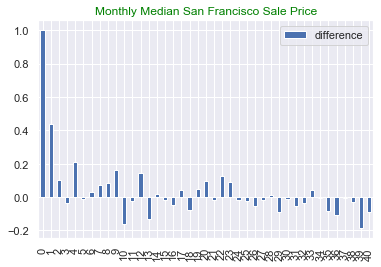

In [22]:
x_acf = pd.DataFrame(pacf(df.diff_1[1:]))
x_acf.plot(kind='bar')
plt.title("Monthly Median San Francisco Sale Price", color="green")
plt.legend(['difference'])

We can conclude the set up for ARIMA as the time sequence is overwhelmingly near zero for all the plots above.  The past values are the AR, the level of differencing is I, and adjusting for past errors is MA.  Let's first start with ARMA before we run ARIMA.

# IV.  ARIMA Model

There are two arguments, which are set up data and the parameter orders.  First, is the dataset and second are three variables, which are the number of lag observations, p, the degree of differencing, d and the size of the moving average window, q.  A value of 1 for p, d or q indicates in use, while a zero indicates not in use.    


In [23]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df.price, order=(1,0,1))
model_fit = model.fit()
#disp=0

print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

/Users/lacivert/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/lacivert/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                  273
Model:                     ARMA(1, 1)   Log Likelihood               -2954.915
Method:                       css-mle   S.D. of innovations          11975.183
Date:                Fri, 24 May 2019   AIC                           5917.830
Time:                        13:09:56   BIC                           5932.268
Sample:                    04-01-1996   HQIC                          5923.626
                         - 12-01-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.273e+05   5.47e+05      1.512      0.132   -2.45e+05     1.9e+06
ar.L1.price     0.9996      0.001   1744.401      0.000       0.998       1.001
ma.L1.price     0.3483      0.044      7.972    

The output is more than we need, but we can focus on a few details in the ARMA model above.  The ar.L1.price section has a confidence interval not crossing zero, but 0.998 and 1.001, which is for good for autoregression.  The moving average in ma.L1.price has similar results with 0.263 and 0.434 with both p values below 0.05 with zero under P>|z|.  

Let's integrate with ARIMA below.  

In [24]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df.price, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                  272
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2919.989
Method:                       css-mle   S.D. of innovations          11112.940
Date:                Fri, 24 May 2019   AIC                           5847.979
Time:                        13:10:29   BIC                           5862.402
Sample:                    05-01-1996   HQIC                          5853.769
                         - 12-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4161.8971   1422.402      2.926      0.004    1374.040    6949.754
ar.L1.D.price     0.6614      0.122      5.406      0.000       0.422       0.901
ma.L1.D.price    -0.2818      0.162     

/Users/lacivert/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/lacivert/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/Users/lacivert/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Not good as our confidence interval goes below zero in the moving average with -0.6 and a p-value greater than 0.05 with 0.084.  Let's tweak our methodology with weighted averages as the time series have evolving averages over time.   

# V.  Exponential Smoothing

To address a seasonal component in the time series data, the Exponential Smoothing Method takes weighted averages of past observations with an exponentially decreasing weight. In other words, the more recent the observations the higher the associated weight.  From a business perspective, recent median sale prices in the past few years in our dataset is of greater signficance than the 1990's because the drivers of price evolve over time.  Just another reason to not select a multi-factor model like multiple linear regression.

In [25]:
# Exponential Smoothing data treatment
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# fit model
model_expSm = SimpleExpSmoothing(df.price) 
model_expSm_fit = model_expSm.fit()

/Users/lacivert/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/lacivert/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


In [26]:
# make a prediction
yhat = model_expSm_fit.predict(len(df.price), len(df.price))
print(yhat)

2019-01-01   1,422,000
Freq: MS, dtype: float64


/Users/lacivert/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


# Next month's San Francisco Median Price is 1,422,000

Text(0.5, 1.0, 'Histogram of Residuals')

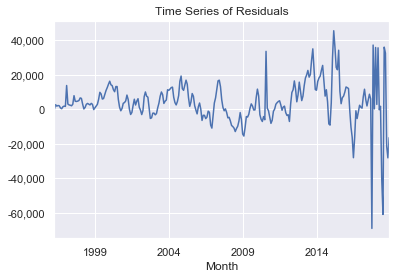

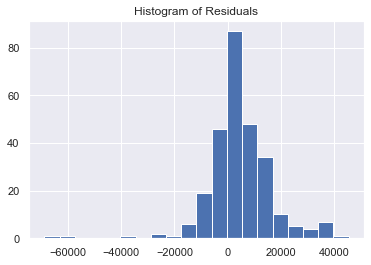

In [27]:
residuals = pd.DataFrame(model_expSm_fit.resid)

n = residuals.plot(legend=False)
n.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.title('Time Series of Residuals')

m = residuals.hist(bins=20)
plt.title('Histogram of Residuals')

A residual data point is the difference between a prediction value and an observed quantity.  Altogether, the residuals resemble a normal distribution with the central tendency near zero so very small amounts of both overshooting and undershooting cancel each other out as time progresses.  The vast majority of historical residuals is a positive or negative 20,000, which is about two and half percent to the historical median or historical average, i.e. more or less 800,000.  We have an acceptable level of error for a predictive model of the median sale price of residential real estate of San Francisco.  

 

# VI. Conclusion

The example dataset from the Zillow website provides a challenging case to predict next month's median sale price, but the available models above can handle the complexity.  Of course, other datasets may be less complicated, but the step by step approach above from data analysis to modeling is a strong approach for predictive analytics of residential real estate pricing.  In addition, both ARIMA and Exponential Smoothing are a single element in a set of equations, respectively, providing room for an extension, if needed.   

# VII. Appendix

__Version List__

Python 3.7.2

NumPy 1.16.3

Pandas 0.24.2

SciPy 1.3.0

Seaborn 0.9.0

MatPlotLib 3.1.0

__Citations__

Seabold, Skipper, and Josef Perktold. “Statsmodels: Econometric and statistical modeling with python.” Proceedings of the 9th Python in Science Conference. 2010.

Skewness:  https://en.wikipedia.org/wiki/Skewness

Kurtosis:  https://en.wikipedia.org/wiki/Kurtosis

Shapiro–Wilk test:  https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test

Autoregressive Model (AR) https://en.wikipedia.org/wiki/Autoregressive_model

Moving Average Model (MA) https://en.wikipedia.org/wiki/Moving-average_model

Autoregressive Integrated Moving Average (ARIMA):  https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average

Exponential Smoothing:  Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice. OTexts, 2014.


